# Vehicle Loading/Unloading Analysis

This notebook calculates and prints loading and unloading man-hours for each vehicle type. Adjust parameters at the top as needed.

Vehicle Loading/Unloading Analysis (Manual vs Machine)

                 Vehicle Type  Length (ft)  No. of Parcels Manual Loading Time (h:m) Machine Loading Time (h:m)  % Time Saved Loading Manual Unloading Time (h:m) Machine Unloading Time (h:m)  % Time Saved Unloading
40 ft ODC Trailer / Container           40            1500                   28h 43m                     6h 35m                  77.1                     26h 33m                        5h 5m                    80.8
          32 ft Container SXL           32             500                    8h 18m                     2h 12m                  73.5                      7h 34m                       1h 42m                    77.6
          32 ft Container MXL           32            1000                   16h 36m                     4h 23m                  73.5                      15h 9m                       3h 23m                    77.6
    24 ft Box/Container Truck           24             700                    9h 49m

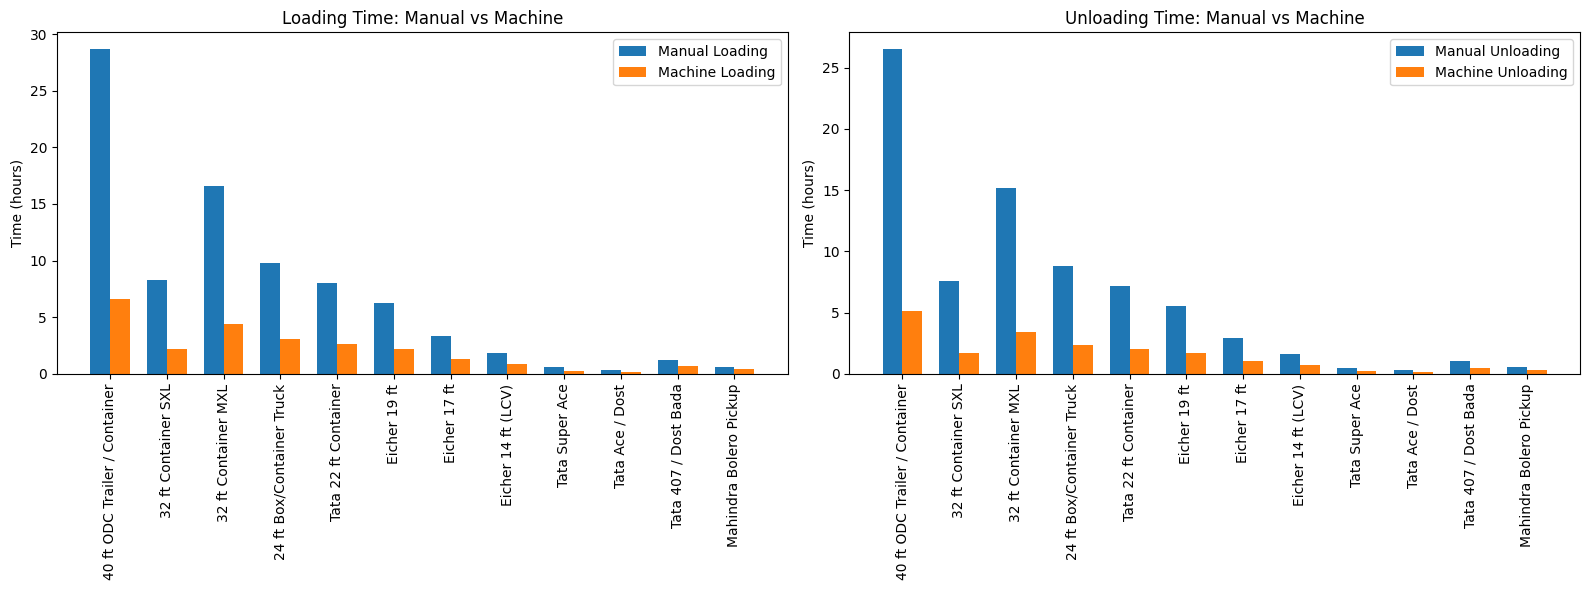

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

VEHICLES = [
    {"type": "40 ft ODC Trailer / Container", "L": 40, "DefaultParcels": 1500},
    {"type": "32 ft Container SXL", "L": 32, "DefaultParcels": 500},
    {"type": "32 ft Container MXL", "L": 32, "DefaultParcels": 1000},
    {"type": "24 ft Box/Container Truck", "L": 24, "DefaultParcels": 700},
    {"type": "Tata 22 ft Container", "L": 22, "DefaultParcels": 600},
    {"type": "Eicher 19 ft", "L": 19, "DefaultParcels": 500},
    {"type": "Eicher 17 ft", "L": 17, "DefaultParcels": 300},
    {"type": "Eicher 14 ft (LCV)", "L": 14, "DefaultParcels": 200},
    {"type": "Tata Super Ace", "L": 14, "DefaultParcels": 65},
    {"type": "Tata Ace / Dost", "L": 12, "DefaultParcels": 45},
    {"type": "Tata 407 / Dost Bada", "L": 9, "DefaultParcels": 150},
    {"type": "Mahindra Bolero Pickup", "L": 8, "DefaultParcels": 90},
]

SPEED_WITHOUT_LOAD = 0.9  # m/s
SPEED_WITH_LOAD = 0.67    # m/s
UNLOADING_DELAY = 10.21   # s (manual)
LOADING_DELAY = 13.8      # s (manual)
TURNING_TIME_PER_PARCEL_S = 2.0

def fatigue_multiplier(parcel_count):
    if parcel_count <= 100:
        return 1.15
    elif parcel_count <= 200:
        return 1.25
    elif parcel_count <= 300:
        return 1.35
    else:
        return 1.45

def format_hours(h):
    return round(h, 2)

def hours_and_minutes(h):
    hours = int(h)
    minutes = int(round((h - hours) * 60))
    return f"{hours}h {minutes}m"

results = []

for v in VEHICLES:
    L = v['L']
    No_Parcels = v['DefaultParcels']
    fatigue_mult = fatigue_multiplier(No_Parcels)
    avg_distance_m = L * 0.3048

    # Walking time (for manual)
    going_time_per_trip_hr = avg_distance_m / SPEED_WITHOUT_LOAD / 3600
    coming_time_per_trip_hr = avg_distance_m / SPEED_WITH_LOAD / 3600
    total_walking_time_hr = (going_time_per_trip_hr + coming_time_per_trip_hr) * No_Parcels * fatigue_mult

    # Manual (human) loading/unloading time (includes walking)
    manual_loading_time_hr = total_walking_time_hr + (LOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600 * fatigue_mult
    manual_unloading_time_hr = total_walking_time_hr + (UNLOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600 * fatigue_mult

    # Machine loading/unloading time (just the loading/unloading, no walking, no fatigue)
    machine_loading_time_hr = (LOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600
    machine_unloading_time_hr = (UNLOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600

    # Percentage time saved
    loading_time_saved_pct = 100 * (1 - (machine_loading_time_hr / manual_loading_time_hr))
    unloading_time_saved_pct = 100 * (1 - (machine_unloading_time_hr / manual_unloading_time_hr))

    results.append({
        "Vehicle Type": v['type'],
        "Length (ft)": L,
        "No. of Parcels": No_Parcels,
        # Remove "Manual Loading Time (h)"
        "Manual Loading Time (h:m)": hours_and_minutes(manual_loading_time_hr),
        # Remove "Machine Loading Time (h)"
        "Machine Loading Time (h:m)": hours_and_minutes(machine_loading_time_hr),
        "% Time Saved Loading": round(loading_time_saved_pct, 1),
        # Remove "Manual Unloading Time (h)"
        "Manual Unloading Time (h:m)": hours_and_minutes(manual_unloading_time_hr),
        # Remove "Machine Unloading Time (h)"
        "Machine Unloading Time (h:m)": hours_and_minutes(machine_unloading_time_hr),
        "% Time Saved Unloading": round(unloading_time_saved_pct, 1)
    })

df = pd.DataFrame(results)

# Display the full table (only h:m columns)
print("Vehicle Loading/Unloading Analysis (Manual vs Machine)\n")
print(df[[
    "Vehicle Type", "Length (ft)", "No. of Parcels",
    "Manual Loading Time (h:m)",
    "Machine Loading Time (h:m)",
    "% Time Saved Loading",
    "Manual Unloading Time (h:m)",
    "Machine Unloading Time (h:m)",
    "% Time Saved Unloading"
]].to_string(index=False))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
bar_width = 0.35
x = range(len(df))

# For plotting, we need the numeric hour values, so recalculate them here
manual_loading_hours = []
machine_loading_hours = []
manual_unloading_hours = []
machine_unloading_hours = []

for v in VEHICLES:
    L = v['L']
    No_Parcels = v['DefaultParcels']
    fatigue_mult = fatigue_multiplier(No_Parcels)
    avg_distance_m = L * 0.3048
    going_time_per_trip_hr = avg_distance_m / SPEED_WITHOUT_LOAD / 3600
    coming_time_per_trip_hr = avg_distance_m / SPEED_WITH_LOAD / 3600
    total_walking_time_hr = (going_time_per_trip_hr + coming_time_per_trip_hr) * No_Parcels * fatigue_mult
    manual_loading_time_hr = total_walking_time_hr + (LOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600 * fatigue_mult
    manual_unloading_time_hr = total_walking_time_hr + (UNLOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600 * fatigue_mult
    machine_loading_time_hr = (LOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600
    machine_unloading_time_hr = (UNLOADING_DELAY + TURNING_TIME_PER_PARCEL_S) * No_Parcels / 3600
    manual_loading_hours.append(manual_loading_time_hr)
    machine_loading_hours.append(machine_loading_time_hr)
    manual_unloading_hours.append(manual_unloading_time_hr)
    machine_unloading_hours.append(machine_unloading_time_hr)

# Loading times
axes[0].bar(x, manual_loading_hours, width=bar_width, label="Manual Loading", color='tab:blue')
axes[0].bar([i + bar_width for i in x], machine_loading_hours, width=bar_width, label="Machine Loading", color='tab:orange')
axes[0].set_xticks([i + bar_width/2 for i in x])
axes[0].set_xticklabels(df["Vehicle Type"], rotation=90)
axes[0].set_ylabel("Time (hours)")
axes[0].set_title("Loading Time: Manual vs Machine")
axes[0].legend()

# Unloading times
axes[1].bar(x, manual_unloading_hours, width=bar_width, label="Manual Unloading", color='tab:blue')
axes[1].bar([i + bar_width for i in x], machine_unloading_hours, width=bar_width, label="Machine Unloading", color='tab:orange')
axes[1].set_xticks([i + bar_width/2 for i in x])
axes[1].set_xticklabels(df["Vehicle Type"], rotation=90)
axes[1].set_ylabel("Time (hours)")
axes[1].set_title("Unloading Time: Manual vs Machine")
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# Optimum timings as per provided data
optimum_loading = {
    "40 ft ODC Trailer / Container": 24,
    "32 ft Container SXL": 10,
    "32 ft Container MXL": 15,
    "24 ft Box/Container Truck": 10,
    "Tata 22 ft Container": 7,
    "Eicher 19 ft": 4.5,
    "Eicher 17 ft": 4.5,
    "Eicher 14 ft (LCV)": 2.7,
    "Tata Super Ace": 1,
    "Tata Ace / Dost": 0.7,
    "Tata 407 / Dost Bada": 1.5,
    "Mahindra Bolero Pickup": 1.1
}

optimum_unloading = {
    "40 ft ODC Trailer / Container": 21,
    "32 ft Container SXL": 7,
    "32 ft Container MXL": 12.5,
    "24 ft Box/Container Truck": 8,
    "Tata 22 ft Container": 7,
    "Eicher 19 ft": 4.2,
    "Eicher 17 ft": 3,
    "Eicher 14 ft (LCV)": 1.95,
    "Tata Super Ace": 0.7,
    "Tata Ace / Dost": 0.4,
    "Tata 407 / Dost Bada": 1.1,
    "Mahindra Bolero Pickup": 0.8
}

# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    "Vehicle Type": list(optimum_loading.keys()),
    "Optimum Loading (h)": list(optimum_loading.values()),
    "Optimum Unloading (h)": list(optimum_unloading.values())
})

# Find your calculated timings (manual loading/unloading) for each vehicle
# Assume df["Vehicle Type"] matches the order and names
comparison_df["Your Loading (h)"] = comparison_df["Vehicle Type"].map(
    dict(zip(df["Vehicle Type"], manual_loading_hours))
)
comparison_df["Your Unloading (h)"] = comparison_df["Vehicle Type"].map(
    dict(zip(df["Vehicle Type"], manual_unloading_hours))
)

# Calculate error percentage
comparison_df["Loading Error (%)"] = (
    (comparison_df["Your Loading (h)"] - comparison_df["Optimum Loading (h)"]).abs() / comparison_df["Optimum Loading (h)"] * 100
)
comparison_df["Unloading Error (%)"] = (
    (comparison_df["Your Unloading (h)"] - comparison_df["Optimum Unloading (h)"]).abs() / comparison_df["Optimum Unloading (h)"] * 100
)

# Display the comparison
print("Comparison of Your Timings vs Optimum Timings (Manual Loading/Unloading):")
display(comparison_df[[
    "Vehicle Type",
    "Optimum Loading (h)", "Your Loading (h)", "Loading Error (%)",
    "Optimum Unloading (h)", "Your Unloading (h)", "Unloading Error (%)"
]])

# Optionally, show mean error
mean_loading_error = comparison_df["Loading Error (%)"].mean()
mean_unloading_error = comparison_df["Unloading Error (%)"].mean()
print(f"\nMean Loading Error: {mean_loading_error:.2f}%")
print(f"Mean Unloading Error: {mean_unloading_error:.2f}%")


Comparison of Your Timings vs Optimum Timings (Manual Loading/Unloading):


,Vehicle Type,Optimum Loading (h),Your Loading (h),Loading Error (%),Optimum Unloading (h),Your Unloading (h),Unloading Error (%)
0,40 ft ODC Trailer / Container,24.0,28.724308,19.684615,21.00,26.555349,26.454044
1,32 ft Container SXL,10.0,8.296204,17.037957,7.00,7.573218,8.188831
2,32 ft Container MXL,15.0,16.592409,10.616057,12.50,15.146436,21.171490
3,24 ft Box/Container Truck,10.0,9.824695,1.753050,8.00,8.812514,10.156431
4,Tata 22 ft Container,7.0,8.037598,14.822824,7.00,7.170014,2.428776
5,Eicher 19 ft,4.5,6.218536,38.189694,4.20,5.495550,30.846431
6,Eicher 17 ft,4.5,3.295245,26.772338,3.00,2.891370,3.621007
7,Eicher 14 ft (LCV),2.7,1.868770,30.786295,1.95,1.619464,16.950539
8,Tata Super Ace,1.0,0.558762,44.123776,0.70,0.484220,30.825731
9,Tata Ace / Dost,0.7,0.364020,47.997196,0.40,0.312413,21.896656



Mean Loading Error: 26.19%
Mean Unloading Error: 17.85%
